# Self-Driving Car Engineer Nanodegree

***

## Project: Finding Lane Lines on the Road
The goal of this project is to detect lane lines on the road using a video feed.  The code will analyze each image frame in the feed and use computer vision techniques to detect the location of the lane lines.

A few assumptions were taken when putting the project together:
* The line color is yellow or white, any lane lines other than this will not be detected
* Assumes the car is in a static, central location in a lane and moving forward.  If the car changes lanes or approaches an intersection where lane lines are not parallel with the forward motion of the car, the program may behave erratic

The code used is Python 3.5 and the following techniques are used for line detection:
* Color Selection
* Canny Edge Detection
* Region of Interest Selection
* Hough Transform Line Detection

For further code documentation or reference on reproducing the project, please refer to the [README](README.md).



### Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math

import cv2
import glob
%matplotlib inline

from collections import deque

### Image Handler Class
Below is a class to read, display and run processing functions on images in a given directory.  This will be used to run the processing algorithms on the images to test the functionality before processing the video feeds

In [2]:
class ImageHandler:
    
    def read(self, directory):
        return [plt.imread(path) for path in glob.glob(directory)]
    
    def save(self, directory, imgs, suffix="", cmap=None):
        for i, img in enumerate(imgs):
            cmap = 'gray' if len(img.shape)==2 else cmap
            plt.imshow(img, cmap=cmap)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout(pad=0, h_pad=0, w_pad=0)
            plt.savefig(directory+"Image"+str(i)+suffix+".jpg")
            plt.close()
        return "done"
        
    def show(self, imgs, cmap=None):
        rows = (len(imgs)+1)//2
        plt.figure(figsize=(10, 11))
        for i, img in enumerate(imgs):
            plt.subplot(rows, 2, i+1)
            cmap = 'gray' if len(img.shape)==2 else cmap
            plt.imshow(img, cmap=cmap)
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout(pad=0, h_pad=0, w_pad=8)
        plt.show()
    
    def process(self, imgs, function):
        return list(map(lambda img: function(img), imgs))
    
    def process_and_append(self, set1, set2, function):
        final = []
        for set1_item, set2_item in zip(set1, set2):
            final.append(function(set1_item, set2_item))
        return final

Let's have a look at the test images:

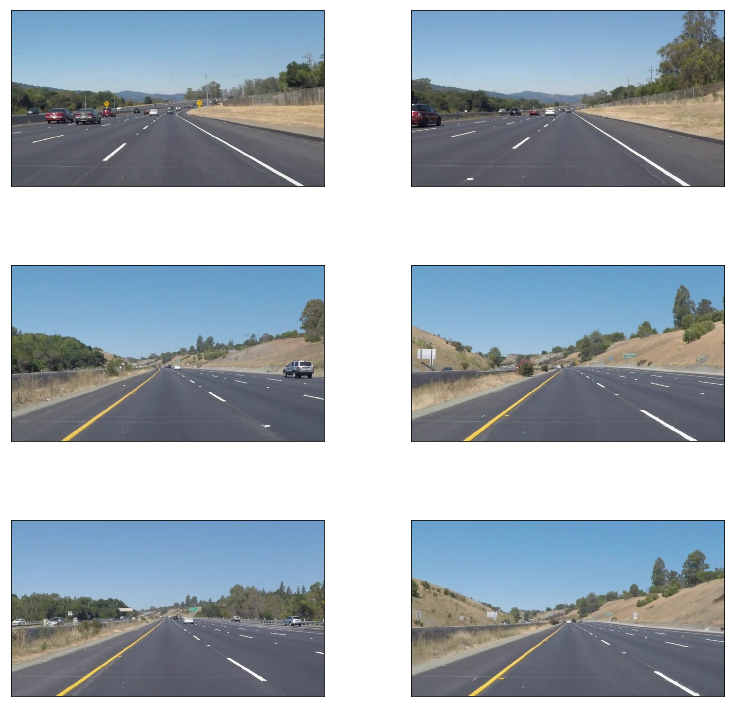

In [3]:
ih = ImageHandler()
imgs = ih.read('test_images/*.jpg')
ih.show(imgs)

In this project we will address detecting the following types of lines: solid yellow, solid white and dotted white.  Also, sunny clear images will be tested.  It may require more complicated processing for night time or poor weather conditions.  

### Image Processor Class

The following class will contain functionality to process images to allow the line finding algorithms to run more accurately

In [4]:
class ImageProcessor:
    
    def rgb_to_hsl(self, img):
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    def rgb_to_hsv(self, img):
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    #This appears to work the best when road hue changes (example: going over a bridge)
    def hsl_to_white_yellow(self, img):
        hsl = self.rgb_to_hsl(img)
        white = cv2.inRange(hsl, np.uint8([ 0 , 200 , 0 ]), np.uint8([ 255 , 255 , 255 ] ))
        yellow = cv2.inRange(hsl, np.uint8([ 13 , 0 , 89 ]), np.uint8([ 55, 255 , 255 ]))
        mask = cv2.bitwise_or(white, yellow)
        return cv2.bitwise_and(img, img, mask = mask)
    
    def hsv_to_white_yellow(self, img):
        hsv = self.rgb_to_hsv(img)
        white = cv2.inRange(hsv, np.uint8([ 0 , 0 , 220 ]), np.uint8([ 255 , 255 , 255 ]))
        yellow = cv2.inRange(hsv, np.uint8([ 13 , 10 , 255 ]), np.uint8([ 55 , 255 , 255 ]))
        mask = cv2.bitwise_or(white, yellow)
        return cv2.bitwise_and(img, img, mask = mask)

    def to_grayscale(self, img):
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    def canny(self, img, low_threshold=55, high_threshold=144):
        return cv2.Canny(img, low_threshold, high_threshold)
    
    def gaussian_blur(self, img, kernel_size=13):
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
    def region_of_interest(self, img):
        """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        """
        #defining a blank mask to start with
        mask = np.zeros_like(img)   

        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, self.get_vertices(img), ignore_mask_color)

        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image
    
    def get_vertices(self, img):
        imshape = img.shape
        return np.array([[(0,imshape[0]+55),(imshape[1]/2-75, imshape[0]/2+70), (imshape[1]/2+75, imshape[0]/2+70), (imshape[1],imshape[0])]], dtype=np.int32)    
    
            
    def weighted_img(self, img, initial_img, α=1., β=0.8, λ=0.):
        return cv2.addWeighted(initial_img, α, img, β, λ)

### Convert to HSL Color Space

Documentation on this color space can be found here: [HSL and HSV](https://en.wikipedia.org/wiki/HSL_and_HSV)

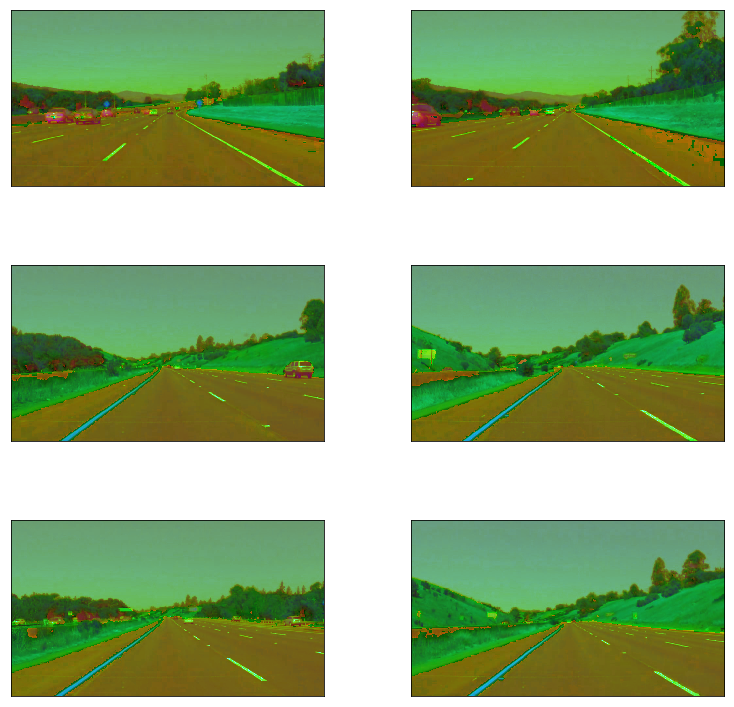

In [5]:
ip = ImageProcessor()
imgs_hsl = ih.process(imgs, ip.rgb_to_hsl)
ih.save('test_images_out/', imgs_hsl, "_hsl")
ih.show(imgs_hsl)

I built the function hsl_to_white_yellow function to extract only white and yellow colors from the hls mask.  This will help with isolating the lane lines and cleaning out any color deviations in the road.  The following OpenCV functions are used:
* cv2.inRange to filter the white and yellow colors into seperate masked images
* cv2.bitwise_or to combine the two masks
* cv2.bitwise_and to merge the combined masks back to the original image

I spent some time tuning the parameters in filtering out colors.  This proves to have a reasonable significance on the quality of the final processing.

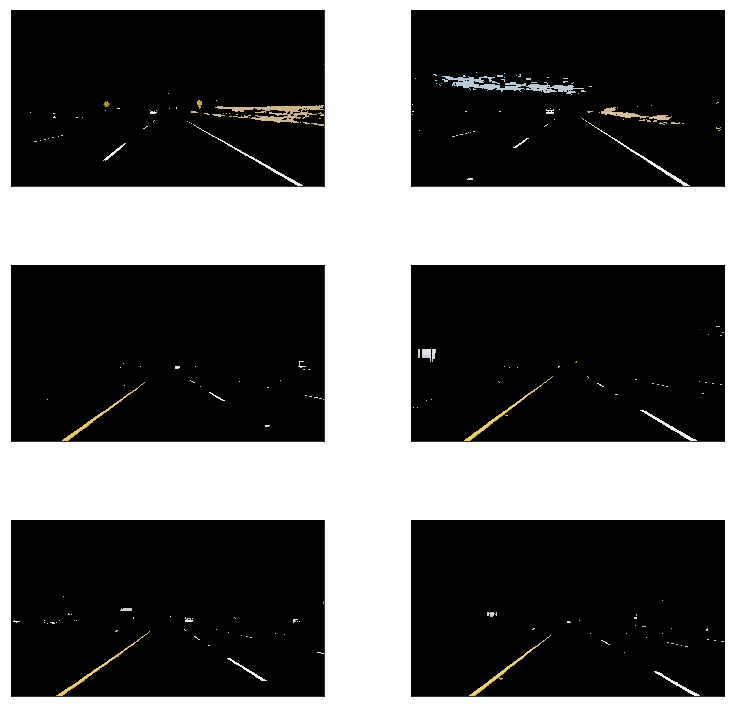

In [6]:
imgs_white_yellow = ih.process(imgs, ip.hsl_to_white_yellow)
#save for writeup
ih.save('test_images_out/', imgs_white_yellow, "_white_yellow")
ih.show(imgs_white_yellow)

It can be seen that the yellow and white lines are clearly shown after processing.
### Canny Edge Detection
Next we will use canny edge detection to detect the line edges.  The OpenCV functions used in this process will include the following:
* Convert the image to grayscale as is required by the canny edge detection algorithm
* Gaussian blur to smooth out rough lines
* Canny edge detection

See wikipedia article on Canny edge detection: [Canny edge detector](https://en.wikipedia.org/wiki/Canny_edge_detector)

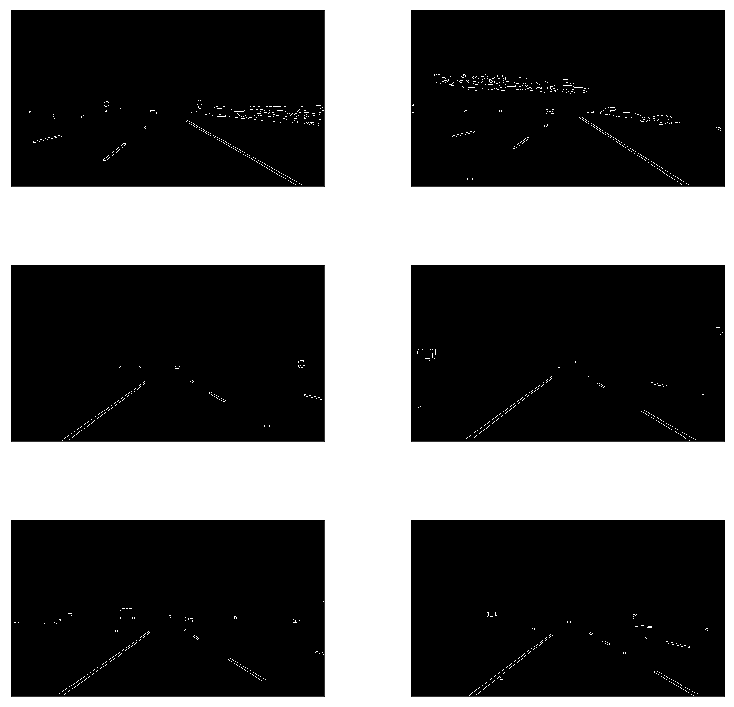

In [7]:
edges = ih.process(ih.process(ih.process(imgs_white_yellow, ip.to_grayscale), ip.gaussian_blur), ip.canny)
ih.save('test_images_out/', edges, "_edges")
ih.show(edges)

### Region Masking

Now that we have the edges, we will mask out any regions of the images that don't matter.  This includes anything above the horizon or far sides of the image.  Doing this will allow us to focus in on only the lane lines.

The OpenCV functions used in this process are:
* cv2.fillPoly to select a pre-defined polygon
* cv2.bitwise_and to merge the selected region back into the original image

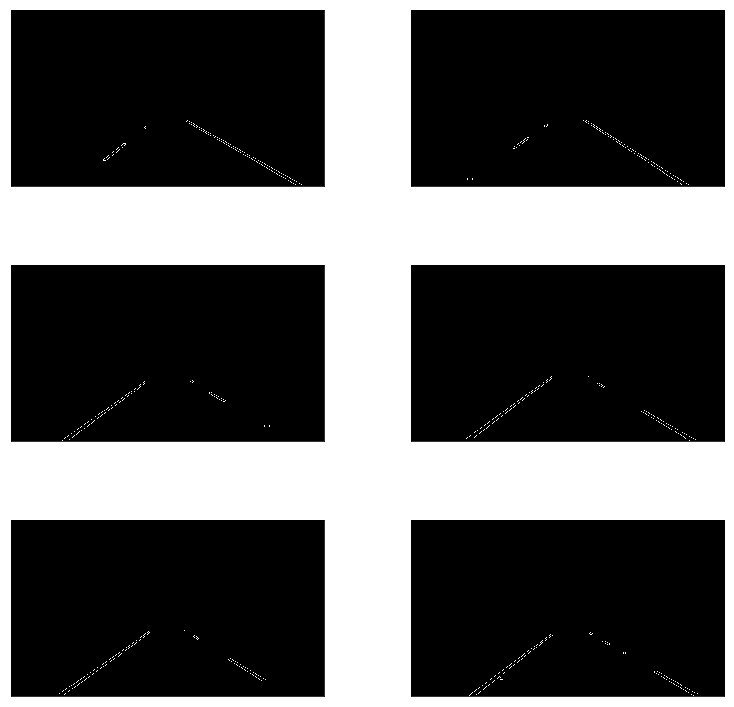

In [8]:
roi_imgs = ih.process(edges, ip.region_of_interest)
ih.save('test_images_out/', roi_imgs, "_roi")
ih.show(roi_imgs)

We have successfully detected only the raw lane lines from the image

### Line Detector Class

The following class will have the OpenCV Hough Line functionality.  It will also contain functionality to draw pre-defined lines on an image.

Documentation on Hough lines can be found here: [Hough transform](https://en.wikipedia.org/wiki/Hough_transform)


In [9]:
class LineDetector:
    
    def get_hough_lines(self, img, rho=1, theta=np.pi/180, threshold=21, min_line_len=21, max_line_gap=233):
        return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        
    def hough_lines(self, img):      
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        self.draw_lines(line_img, self.get_hough_lines(img))
        return line_img
    
    def draw_lines(self, img, lines, color=[255, 0, 0], thickness=2):
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1,y1), (x2,y2), color, thickness)
        return img

The following function will take the edges detected in the Canny edge detection algorithm and detect the actual lines that will be stored as vertex points.  This step is crucial in taking raw data from the image files and converting it to mathematically modeled lines that can be used in computer algorithms.

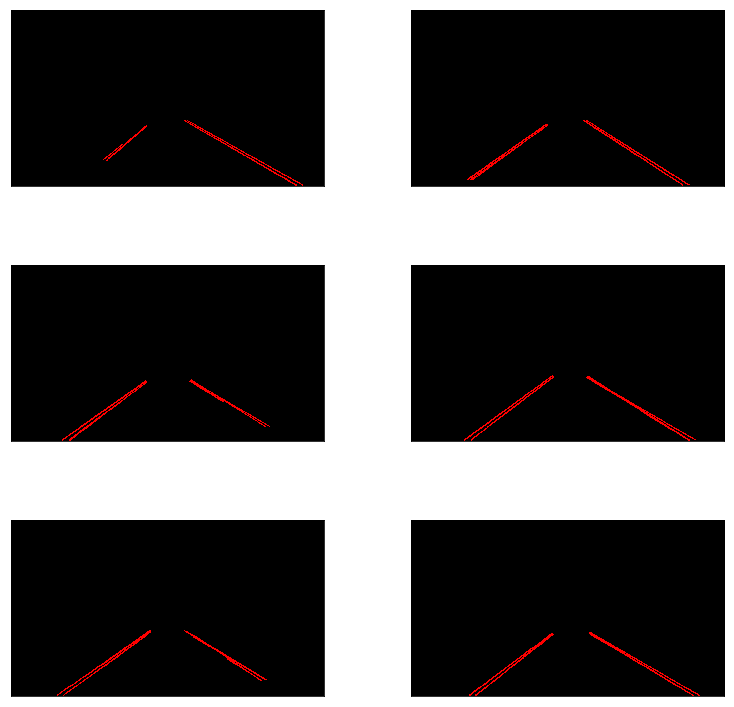

In [10]:
ld = LineDetector()

line_imgs = ih.process(roi_imgs, ld.hough_lines)

ih.show(line_imgs)

Now that we have the lines, lets draw them back onto the original image for viewing purposes

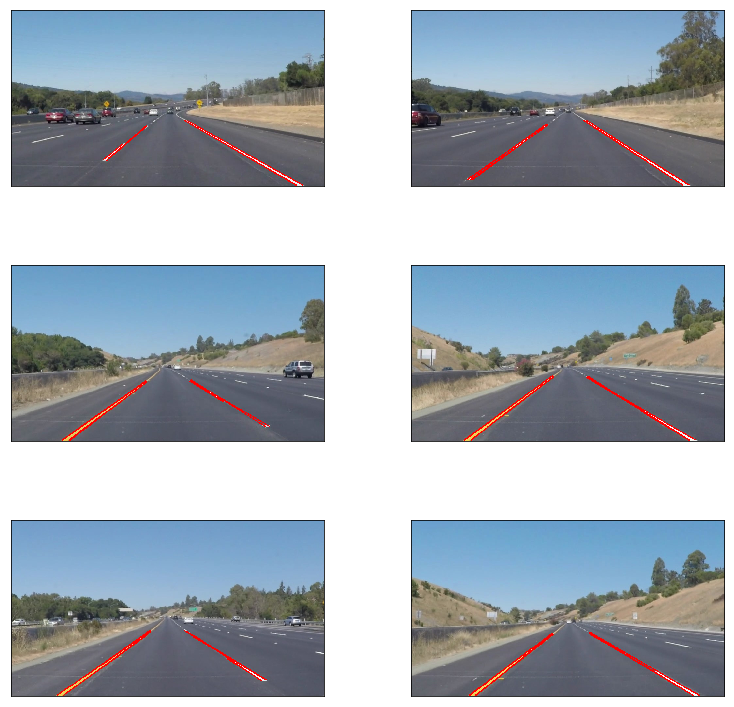

In [11]:
imgs2 = np.copy(imgs)
roi_hough_lines = ih.process(roi_imgs, ld.get_hough_lines)
imgs_w_lines = ih.process_and_append(imgs2, roi_hough_lines, ld.draw_lines)
ih.save('test_images_out/', imgs_w_lines, "_lines")
ih.show(imgs_w_lines)

In [12]:
class LineProcessor:
    
    """   
    the below formulas calculate a linear regression on the set of hough lines
    it gives equal weight to each line detected from the hough line function

    this proved to not be as robust due to smaller lines causing increase fluctuation in the fitted line slope
    simply selecting the largest detected hough line give a more accurate representation of the physical lane lines
    """
    def get_linear_fit(self, x_set, y_set): #not currently used
        X = np.array(x_set)
        Y = np.array(y_set)

        XdotX = X.dot(X)
        Xmean = X.mean()
        Xsum = X.sum()
        XdotY = X.dot(Y)
        Ymean = Y.mean()
        denominator = XdotX - Xmean * Xsum
        a = (  XdotY - Ymean * Xsum  ) / denominator
        b = ( Ymean * XdotX - Xmean * XdotY ) / denominator

        return a,b
    
    def get_left_right(self, lines):
        left = None
        right = None
        left_line_size = 0
        right_line_size = 0
        
        for line in lines:
            for x1, y1, x2, y2 in line:
                if x2==x1:
                    continue  # igonore vertical
                a = (y2-y1)/(x2-x1)
                b = y1-a*x1
                length = np.sqrt((y2-y1)**2+(x2-x1)**2)
                if a < 0: # left lane detected
                    if length > left_line_size:
                        left_line_size = length
                        left = a,b
                else: # right lane detected
                    if length > right_line_size:
                        right_line_size = length
                        right = a,b
        return left,right
    
    def get_line_verticies(self, line):
        if type(line) is np.ndarray:
            line = line.tolist()[0]
        half = int(len(line)/2)
        return line[:half], line[half:]
    
    def lines_to_verticies(self, lines):
        verticies = []
        for line in lines:
            for vertex in self.get_line_verticies(line):
                verticies.append(vertex) 
        verticies.sort()
        return np.array([verticies])
    
    def build_line(self, y1, y2, formula):
        if formula is not None:
            a, b = formula
            if a != 0:
                return [int((y1-b)/a), int(y1), int((y2-b)/a), int(y2)]
            else:
                return None
        else:
            return None
        
    """
    This function takes a list of lines and finds the average of all the lines.
    """
    def find_centerline(self, lines):
        if len(lines)>0:
            return np.mean(lines, axis=0, dtype=np.int32)
        else:
            return None

### Lane Detector Class
The following class uses all the classes and functions previously defined in the project to detect and extrapolate lane lines from an image.  The class can be used later in the video feed processing pipeline

In [13]:
class LaneDetector:
    
    def __init__(self):
        self.LENGTH = 13 #Build a simple moving average algorithm for smoothing of detected lines
        self.ip = ImageProcessor()
        self.ld = LineDetector()
        self.lp = LineProcessor()
        self.left_lines = deque(maxlen=self.LENGTH)
        self.right_lines = deque(maxlen=self.LENGTH)
        
    def get_edges(self, img):
        mask = ip.hsl_to_white_yellow(img)
        gray = self.ip.to_grayscale(mask)
        blurred = self.ip.gaussian_blur(gray)
        return self.ip.canny(blurred)
        
    def get_raw_lane_lines(self, img):
        edges = self.get_edges(img)
        roi = self.ip.region_of_interest(edges)
        return self.ld.get_hough_lines(roi)
    
    def get_lane_lines(self, img):
        y1 = img.shape[0]
        y2 = y1*0.618
        lines = self.get_raw_lane_lines(img)
        left_formula, right_formula = self.lp.get_left_right(lines)
        return [self.lp.build_line(y1, y2, left_formula), self.lp.build_line(y1, y2, right_formula)]
    
    def get_lane_lines_smooth(self, img):
        [left_line, right_line] = self.get_lane_lines(img)
        right_smooth = self.apply_smoothing(right_line, self.right_lines)
        left_smooth = self.apply_smoothing(left_line, self.left_lines)
        return [left_smooth.tolist() if left_smooth is not None else None, right_smooth.tolist() if right_smooth is not None else None]
    
    def get_centerline(self, img):
        lines = self.get_lane_lines_smooth(img)
        centerline = self.lp.find_centerline(lines)
        return [centerline]
    
    def draw_lane_lines(self, img, lines, color=[255, 0, 0], thickness=13):
        line_img = np.zeros_like(img)
        self.ld.draw_lines(line_img, [lines], color, thickness)
        return self.ip.weighted_img(line_img, img)
    
    def draw_raw_lines(self, img, lines, color=[255, 0, 0], thickness=3):
        line_img = np.zeros_like(img)
        self.ld.draw_lines(line_img, lines, color, thickness)
        return self.ip.weighted_img(line_img, img, 0.89)
    
    def detect_centerline(self, img):
        return self.draw_lane_lines(img, self.get_centerline(img))
    
    def detect_lane_lines(self, img):
        return self.draw_lane_lines(img, self.get_lane_lines(img))
    
    def detect_lane_lines_smooth(self, img):
        return self.draw_lane_lines(img, self.get_lane_lines_smooth(img))
    
    def detect_raw_lane_lines(self, img):
        return self.draw_raw_lines(img, self.get_raw_lane_lines(img))
    
    def apply_smoothing(self, line, lines):
        if line is not None:
            lines.append(line)
        return self.lp.find_centerline(lines)
    
    def get_line_queue(self):
        return self.left_lines, self.right_lines
    
    def detect_lane_zone_raw(self, img):
        zone = np.zeros_like(img)
        cv2.fillPoly(zone, self.lp.lines_to_verticies(self.get_raw_lane_lines(img)), [0 , 255, 0])
        return self.ip.weighted_img(img, zone, α=0.34)  
    
    def detect_lane_zone(self, img):
        zone = np.zeros_like(img)
        cv2.fillPoly(zone, self.lp.lines_to_verticies(self.get_lane_lines(img)), [0 , 255, 0])
        return self.ip.weighted_img(img, zone, α=0.34)    
    
    def detect_lane_zone_smooth(self, img):
        zone = np.zeros_like(img)
        cv2.fillPoly(zone, self.lp.lines_to_verticies(self.get_lane_lines_smooth(img)), [0 , 255, 0])
        return self.ip.weighted_img(img, zone, α=0.34) 

Now we will used the Lane Detector class to detect and extrapolate lane lines on the original images

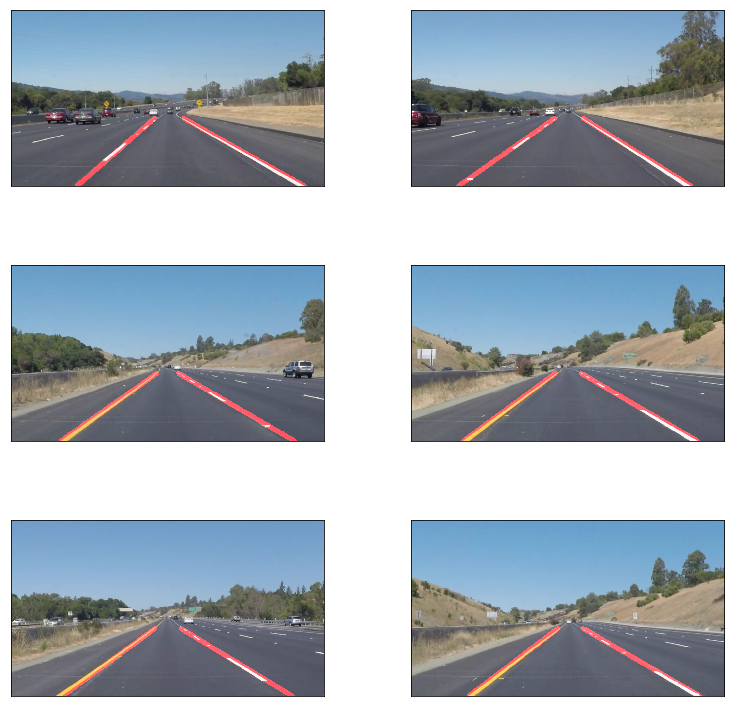

In [14]:
detector = LaneDetector()
detected_lanes = ih.process(imgs, detector.detect_lane_lines)
ih.save('test_images_out/', detected_lanes, "_lanes")
ih.show(detected_lanes)

### Bonus items
The following items were not specified as requirements in the project but I decided to pursue them for further learning and understanding.

1. The first set of images uses a lane zone detecting algorithm to detect the area inside the lane from the raw hough lines.
2. The second set shows an extrapolated lane area
3. The third set shows the lane centerline

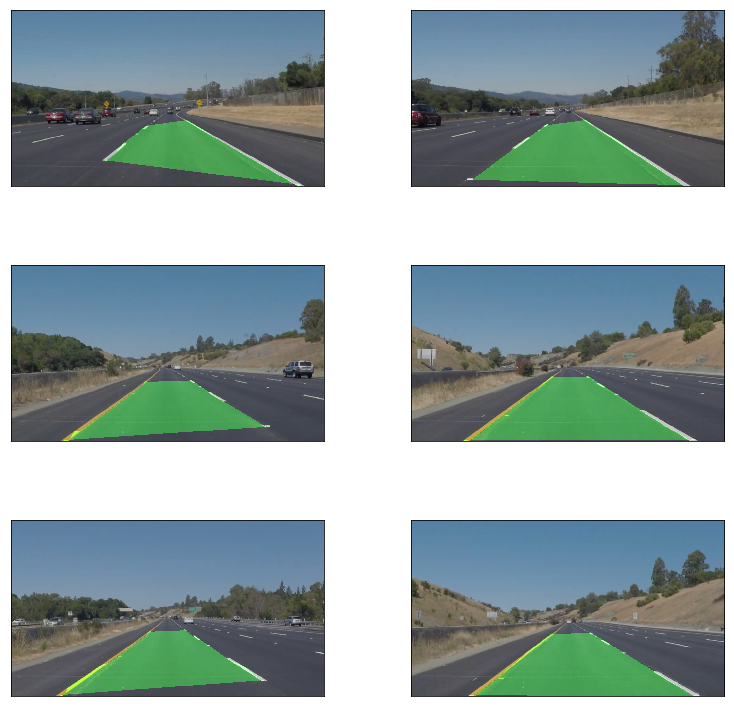

In [15]:
raw_zone_imgs = ih.process(imgs, detector.detect_lane_zone_raw)
ih.show(raw_zone_imgs)

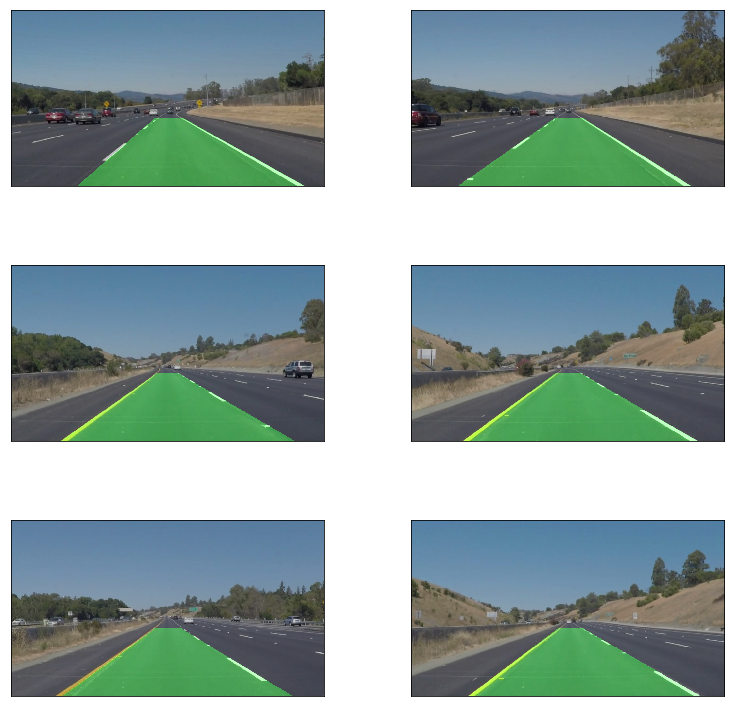

In [16]:
zone_imgs = ih.process(imgs, detector.detect_lane_zone)
ih.save('test_images_out/', zone_imgs, "_zones")
ih.show(zone_imgs)

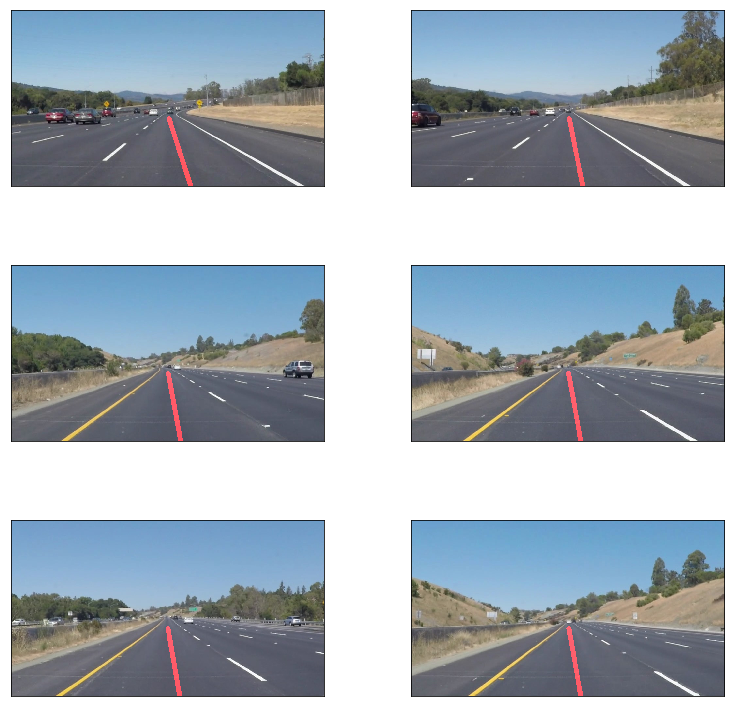

In [17]:
centerline_imgs = ih.process(imgs, detector.detect_centerline)
ih.show(centerline_imgs)

### Video Processing
Now comes the fun part.  Below is a Video Processor class that uses the Lane Detector class as a dependency.  It will read a mp4 video file in and process each frame.

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
class VideoProcessor:
    detector = LaneDetector()
    
    def save_to_file(self, video_input, video_output, function):
        self.detector = LaneDetector()
        clip1 = VideoFileClip(video_input)
        clip = clip1.fl_image(function) #NOTE: this function expects color images!!
        %time clip.write_videofile(video_output, audio=False)
        clip1.reader.close()
    
    def detect_lane_lines(self, img):
        return self.detector.detect_lane_lines(img)
    
    def detect_smooth_lane_lines(self, img):        
        return self.detector.detect_lane_lines_smooth(img)
    
    def detect_raw_lane_lines(self, img):
        return self.detector.detect_raw_lane_lines(img)
    
    def detect_lane_zone(self, img):
        return self.detector.detect_lane_zone(img)
    
    def detect_lane_zone_raw(self, img):
        return self.detector.detect_lane_zone_raw(img)
    
    def detect_lane_zone_smooth(self, img):
        return self.detector.detect_lane_zone_smooth(img)
    
    def detect_centerline(self, img):
        return self.detector.detect_centerline(img)
    
    def detect_edges(self, img):
        return self.detector.get_edges(img)
        

In [20]:
vp = VideoProcessor()

### Using raw hough lines:

In [21]:
vp.save_to_file("test_videos/solidWhiteRight.mp4", "test_video_output/solidWhiteRight_raw.mp4", vp.detect_raw_lane_lines)

[MoviePy] >>>> Building video test_video_output/solidWhiteRight_raw.mp4
[MoviePy] Writing video test_video_output/solidWhiteRight_raw.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:07<00:00, 23.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/solidWhiteRight_raw.mp4 

Wall time: 7.97 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_output/solidWhiteRight_raw.mp4"))

In [23]:
vp.save_to_file("test_videos/solidYellowLeft.mp4", "test_video_output/solidYellowLeft_raw.mp4", vp.detect_raw_lane_lines)

[MoviePy] >>>> Building video test_video_output/solidYellowLeft_raw.mp4
[MoviePy] Writing video test_video_output/solidYellowLeft_raw.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:21<00:00, 31.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/solidYellowLeft_raw.mp4 

Wall time: 22.7 s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_output/solidYellowLeft_raw.mp4"))

In [25]:
vp.save_to_file("test_videos/challenge.mp4", "test_video_output/challenge_raw.mp4", vp.detect_raw_lane_lines)

[MoviePy] >>>> Building video test_video_output/challenge_raw.mp4
[MoviePy] Writing video test_video_output/challenge_raw.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 16.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/challenge_raw.mp4 

Wall time: 16.8 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_output/challenge_raw.mp4"))

### Using line fitting with no smoothing:

In [27]:
vp.save_to_file("test_videos/solidWhiteRight.mp4", "test_video_output/solidWhiteRight_fit.mp4", vp.detect_lane_lines)

[MoviePy] >>>> Building video test_video_output/solidWhiteRight_fit.mp4
[MoviePy] Writing video test_video_output/solidWhiteRight_fit.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:08<00:00, 20.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/solidWhiteRight_fit.mp4 

Wall time: 9.62 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_output/solidWhiteRight_fit.mp4"))

In [29]:
vp.save_to_file("test_videos/solidYellowLeft.mp4", "test_video_output/solidYellowLeft_fit.mp4", vp.detect_lane_lines)

[MoviePy] >>>> Building video test_video_output/solidYellowLeft_fit.mp4
[MoviePy] Writing video test_video_output/solidYellowLeft_fit.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:31<00:00, 21.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/solidYellowLeft_fit.mp4 

Wall time: 32.3 s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_output/solidYellowLeft_fit.mp4"))

In [31]:
vp.save_to_file("test_videos/challenge.mp4", "test_video_output/challenge_fit.mp4", vp.detect_lane_lines)

[MoviePy] >>>> Building video test_video_output/challenge_fit.mp4
[MoviePy] Writing video test_video_output/challenge_fit.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:18<00:00, 13.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/challenge_fit.mp4 

Wall time: 20.6 s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_output/challenge_fit.mp4"))

It is pretty clear that the raw fitted lines jump around.  To smooth them out, I used a deque from Python collections, which works similar to a moving average of the lines.

### Using line fitting with smoothing

In [33]:
vp.save_to_file("test_videos/solidWhiteRight.mp4", "test_video_output/solidWhiteRight_smooth.mp4", vp.detect_smooth_lane_lines)

[MoviePy] >>>> Building video test_video_output/solidWhiteRight_smooth.mp4
[MoviePy] Writing video test_video_output/solidWhiteRight_smooth.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:09<00:00, 23.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/solidWhiteRight_smooth.mp4 

Wall time: 11.4 s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_output/solidWhiteRight_smooth.mp4"))

In [35]:
vp.save_to_file("test_videos/solidYellowLeft.mp4", "test_video_output/solidYellowLeft_largest_smooth.mp4", vp.detect_smooth_lane_lines)

[MoviePy] >>>> Building video test_video_output/solidYellowLeft_largest_smooth.mp4
[MoviePy] Writing video test_video_output/solidYellowLeft_largest_smooth.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:27<00:00, 24.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/solidYellowLeft_largest_smooth.mp4 

Wall time: 28.9 s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_output/solidYellowLeft_largest_smooth.mp4"))

In [37]:
vp.save_to_file("test_videos/challenge.mp4", "test_video_output/challenge_largest_smooth.mp4", vp.detect_smooth_lane_lines)

[MoviePy] >>>> Building video test_video_output/challenge_largest_smooth.mp4
[MoviePy] Writing video test_video_output/challenge_largest_smooth.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:19<00:00, 12.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/challenge_largest_smooth.mp4 

Wall time: 21.1 s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_output/challenge_largest_smooth.mp4"))

### Bonus Items:
The following cells process the test videos for the centerline and lane zone detection.

In [39]:
vp.save_to_file("test_videos/solidYellowLeft.mp4", "test_video_output/solidYellowLeft_centerline.mp4", vp.detect_centerline)

[MoviePy] >>>> Building video test_video_output/solidYellowLeft_centerline.mp4
[MoviePy] Writing video test_video_output/solidYellowLeft_centerline.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:28<00:00, 24.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/solidYellowLeft_centerline.mp4 

Wall time: 29.1 s


In [40]:
vp.save_to_file("test_videos/challenge.mp4", "test_video_output/challenge_centerline.mp4", vp.detect_centerline)

[MoviePy] >>>> Building video test_video_output/challenge_centerline.mp4
[MoviePy] Writing video test_video_output/challenge_centerline.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:17<00:00, 14.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/challenge_centerline.mp4 

Wall time: 18.9 s


In [41]:
vp.save_to_file("test_videos/solidYellowLeft.mp4", "test_video_output/solidYellowLeft_zone_raw.mp4", vp.detect_lane_zone_raw)

[MoviePy] >>>> Building video test_video_output/solidYellowLeft_zone_raw.mp4
[MoviePy] Writing video test_video_output/solidYellowLeft_zone_raw.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:25<00:00, 26.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/solidYellowLeft_zone_raw.mp4 

Wall time: 26.8 s


In [42]:
vp.save_to_file("test_videos/challenge.mp4", "test_video_output/challenge_zone_raw.mp4", vp.detect_lane_zone_raw)

[MoviePy] >>>> Building video test_video_output/challenge_zone_raw.mp4
[MoviePy] Writing video test_video_output/challenge_zone_raw.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:17<00:00, 14.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/challenge_zone_raw.mp4 

Wall time: 18.8 s


In [43]:
vp.save_to_file("test_videos/solidYellowLeft.mp4", "test_video_output/solidYellowLeft_zone.mp4", vp.detect_lane_zone_smooth)

[MoviePy] >>>> Building video test_video_output/solidYellowLeft_zone.mp4
[MoviePy] Writing video test_video_output/solidYellowLeft_zone.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:25<00:00, 26.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/solidYellowLeft_zone.mp4 

Wall time: 26.3 s


In [44]:
vp.save_to_file("test_videos/challenge.mp4", "test_video_output/challenge_zone.mp4", vp.detect_lane_zone_smooth)

[MoviePy] >>>> Building video test_video_output/challenge_zone.mp4
[MoviePy] Writing video test_video_output/challenge_zone.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:17<00:00, 14.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/challenge_zone.mp4 

Wall time: 18.7 s


### Lane centerline finding algorithm with smoothing

In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_output/solidYellowLeft_centerline.mp4"))

In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_output/challenge_centerline.mp4"))

### Zone detection

In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_output/solidYellowLeft_zone_raw.mp4"))

In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_output/challenge_zone_raw.mp4"))

### Zone detection with smoothing and extrapolation

In [49]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_output/solidYellowLeft_zone.mp4"))

In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_output/challenge_zone.mp4"))

### Conclusions

The project was successful in both finding the actual lane lines from the video feeds and extrapolating the raw line data into an average curve formula to estimate lane line location.  